# Where is the best place to start a new restaurant business in the US?
Using the Food Environment Atlas dataset, I will investigate where in the US is there likely to be highest demand for a new restaurant.

The number of restaurants per population is surprisingly stable, with most places in the US having approximately the same restaurant density. This means that if a company can determine where the restaurant density is lower than expected, then they can estimate where the demand for another restaurant will be highest.

## Reading and cleaning data

In [1]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Read the relevant sheets of the Excel file as a dictionary of Pandas dateframes
dict_FEA = pd.read_excel('Food_Environment_Atlas.xls', ['Supplemental Data - County', 'STORES', 'RESTAURANTS'])

# Extract population and restaurant data as separate dataframes
df_FEA_pop = dict_FEA['Supplemental Data - County']
df_FEA_rest = dict_FEA['RESTAURANTS']

Inspect column headings to understand data structure:

In [3]:
print(df_FEA_pop.columns)
print(df_FEA_rest.columns)

Index(['FIPS ', 'State', 'County', '2010 Census Population',
       'Population Estimate, 2011', 'Population Estimate, 2012',
       'Population Estimate, 2013', 'Population Estimate, 2014',
       'Population Estimate, 2015', 'Population Estimate, 2016'],
      dtype='object')
Index(['FIPS', 'State', 'County', 'FFR09', 'FFR14', 'PCH_FFR_09_14',
       'FFRPTH09', 'FFRPTH14', 'PCH_FFRPTH_09_14', 'FSR09', 'FSR14',
       'PCH_FSR_09_14', 'FSRPTH09', 'FSRPTH14', 'PCH_FSRPTH_09_14',
       'PC_FFRSALES07', 'PC_FFRSALES12', 'PC_FSRSALES07', 'PC_FSRSALES12'],
      dtype='object')


The first heading of the population dataframe has a space after 'FIPS'. Let's correct that by renaming the column.

In [4]:
df_FEA_pop.rename(columns = {'FIPS ':'FIPS'}, inplace = True)

All the state names in the population dataframe have a space at the start of their string. Let's remove that. The population values are strings with commas in them. Let's remove the commas and make the populations integers.

In [5]:
# Remove space at start of state names
df_FEA_pop['State'] = df_FEA_pop['State'].apply(lambda state: state[1:])

pop_cols = ['2010 Census Population',
        'Population Estimate, 2011', 'Population Estimate, 2012',
       'Population Estimate, 2013', 'Population Estimate, 2014',
       'Population Estimate, 2015', 'Population Estimate, 2016']

for col_name in pop_cols:
    df_FEA_pop[col_name] = df_FEA_pop[col_name].apply(lambda pop: int(pop.replace(',', '')))

I want to combine the population and the restaurant dataframes, but I first need to make sure that their shapes are compatible.

In [6]:
# Shape of the dataframe of the county population data
print(df_FEA_pop.shape)

# Shape of the dataframe of the restaurant data
print(df_FEA_rest.shape)

(3142, 10)
(3143, 19)


There is one more row in the restaurants data compared to the population data so the dataframes cannot yet be combined. The rows correspond to US counties. Let's remove the rows which correspond to counties that are not in both dataframes.

In [7]:
# Define new dataframes as subsets of population and restaurant dataframes but where rows which
# are not contained in both are removed. Reindex so that indices are compatible.
df_FEA_pop2 = df_FEA_pop[df_FEA_pop['FIPS'].isin(df_FEA_rest['FIPS'])].reset_index(drop=True)
df_FEA_rest2 = df_FEA_rest[df_FEA_rest['FIPS'].isin(df_FEA_pop['FIPS'])].reset_index(drop=True)

# Check that the number of rows match now.
print(df_FEA_pop2.shape, df_FEA_rest2.shape)

# Final check that the county identification numbers (FIPS) now match up (should be 0 if all match).
print((df_FEA_pop2['FIPS'] != df_FEA_rest2['FIPS']).sum())

(3140, 10) (3140, 19)
0


Now we can combine the dataframes into one.

In [8]:
# Combine dataframes into one, dropping the FIPS, state, and county columns in the restaurant dataframe as they are already
# in the population dateframe.
df_FEA = pd.concat([df_FEA_pop2, df_FEA_rest2.drop(['FIPS', 'State', 'County'], axis=1)], axis=1)

## Asset 1 - Restaurant density map
Let's see how restaurant density is distributed across US states. To do this, we need to group the data by state and sum over the other columns. Column names 'FSR14' and 'FFR14' correspond to number of fast-food and full-service restaurants, respectively, in 2014.

In [9]:
df_FEA_state = df_FEA[['State', 'Population Estimate, 2014', 'FSR14', 'FFR14']].groupby('State').sum()

# Just checking we have done that correctly.
df_FEA_state.head()

,"Population Estimate, 2014",FSR14,FFR14
State,,,
Alabama,4843214,2777,3561
Alaska,728642,566,429
Arizona,6719993,4053,4211
Arkansas,2966912,1929,1939
California,38680810,29796,28292


We are interested in the total number of restaurants, so we need to sum the fast-food and full service restaurant columns. Then let's add a columnn for the number of restaurants per 1000 population in 2014 for each state.

In [10]:
# Sum columns
df_FEA_state['tot14'] = df_FEA_state['FSR14'] + df_FEA_state['FFR14']

# Create column for restaurant density
df_FEA_state['tot_per_1000pop14'] = 1000*df_FEA_state['tot14'] / df_FEA_state['Population Estimate, 2014']

# Check
df_FEA_state.head()

,"Population Estimate, 2014",FSR14,FFR14,tot14,tot_per_1000pop14
State,,,,,
Alabama,4843214,2777,3561,6338,1.308635
Alaska,728642,566,429,995,1.365554
Arizona,6719993,4053,4211,8264,1.229763
Arkansas,2966912,1929,1939,3868,1.303712
California,38680810,29796,28292,58088,1.501727


District of Columbia has a far higher number of restaurants per population than any other state. Let's create another dataframe without that state so that it does not unfairly skew the data.

In [11]:
df_FEA_state_dropDoC = df_FEA_state.drop('District of Columbia', axis=0)

Let' visualise the density of restaurnats across US states. We'll do this by plotting on the US map using a the Python package Cartopy.

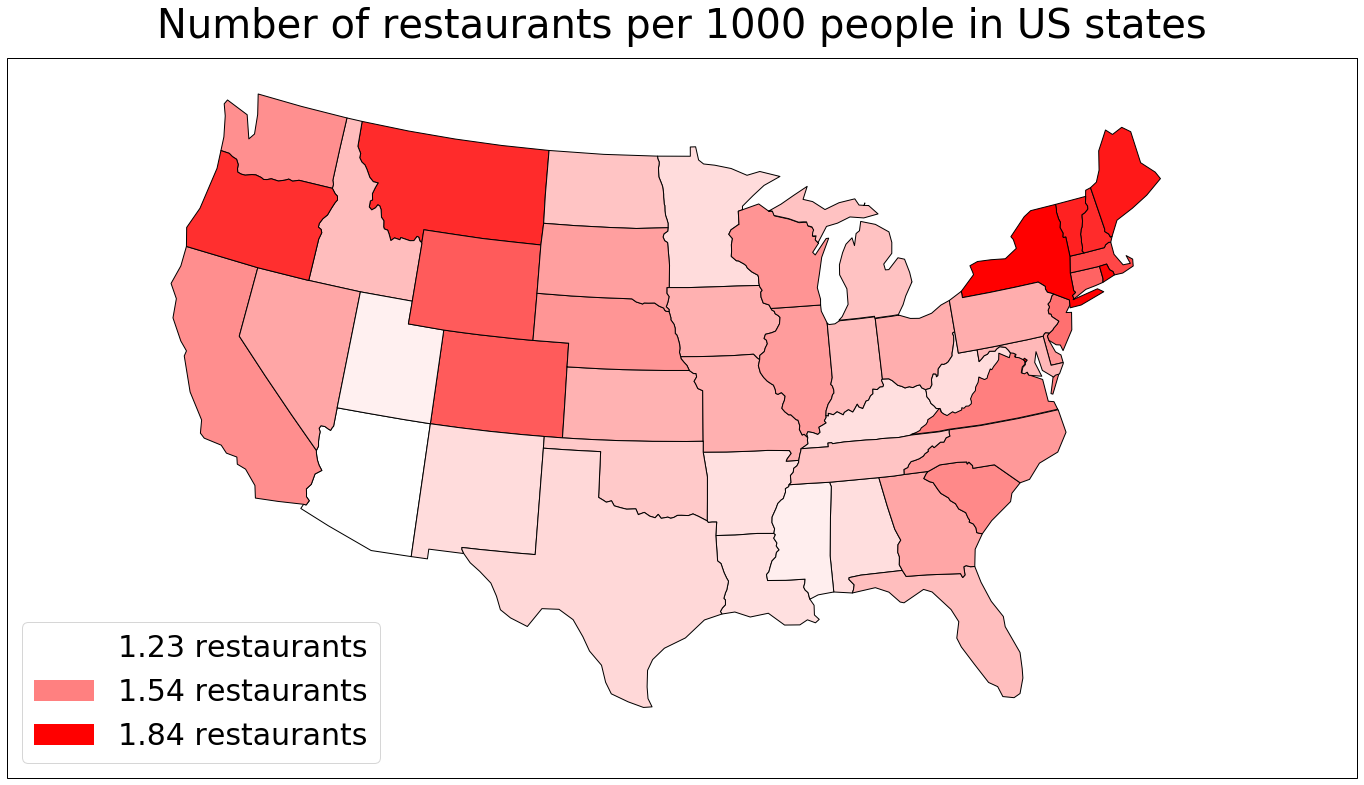

In [12]:
# Initialise figure
fig = plt.figure(figsize=(19,10))
     
# Define map projection type
ax = plt.axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

# Download shape data for US state boundaries.
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# Extreme values and range used to normalise data.
min_tot = df_FEA_state_dropDoC['tot_per_1000pop14'].min()
max_tot = df_FEA_state_dropDoC['tot_per_1000pop14'].max()
range_tot = max_tot - min_tot

for astate in shpreader.Reader(states_shp).records():
    edgecolor = 'black'

    try:
        # use the name of this state to get tot_per_pop14 value
        state_tot = df_FEA_state_dropDoC['tot_per_1000pop14'].to_dict()[astate.attributes['name']]
        
        # Normalise
        state_tot_norm = (state_tot - min_tot)/range_tot
        
        # assign color to each state
        facecolor = [1, 1 - state_tot_norm, 1 - state_tot_norm]

    except:
        # If the state does not have a value for tot_per_pop14, color it white.
        # (this is only true for District of Columbia which we dropped.)
        facecolor = [1, 0, 0]

    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

# make two proxy artists to add to a legend
min_patch = mpatches.Rectangle((0, 0), 1, 1, facecolor=[1, 1, 1])
mid_patch = mpatches.Rectangle((0, 0), 1, 1, facecolor=[1, 0.5, 0.5])
max_patch = mpatches.Rectangle((0, 0), 1, 1, facecolor=[1, 0, 0])
labels = ["%.2f" % min_tot + ' restaurants',
          "%.2f" % ((min_tot + max_tot)/2) + ' restaurants',
          "%.2f" % max_tot + ' restaurants']
plt.legend([min_patch, mid_patch, max_patch], labels,
           loc='lower left', fancybox=True, fontsize=30)

ax.set_title("Number of restaurants per 1000 people in US states", fontsize=40, pad = 20)

plt.show()

It is quite remarkable just how small the range of values is. The state with the highest number of restaurants per 1000 people has just 1.5 times that of the state with the lowest. We can work this out exactly as:

In [13]:
# How many times more restaurants are there per 1000 people in the state with the highest restaurant-density
# compared to the state with the lowest?
df_FEA_state_dropDoC['tot_per_1000pop14'].max() / df_FEA_state_dropDoC['tot_per_1000pop14'].min()

1.500220390105942

## Asset 2 - Comparing restaurant density to supermarket density
Of course, the restaurant density is not the only factor for estimating the demand for a new restaurant. It is useful to try to determine why certain counties have a lower restaurant density. One possibility is that the population generally visits restaurants less, perhaps tdue to financial, cultural, or other reasons. If this were the case, then we might expect that the number of supermarkets per population would be higher in those counties with lower restaurant density, i.e. the population are buying food to eat in rather than eating out at restaurants. Let's investigate this.

First, lets create a dateframe for the store data.

In [14]:
# Extracting store data from the dictionary.
df_FEA_stor = dict_FEA['STORES']

Check the shape to see whether it's compatible with the restaurant and population dataframes.

In [15]:
df_FEA_stor.shape

(3143, 39)

The number of rows is more than the number of rows in the previous dataset, so lets remove the rows that are not comtainded in both.

In [16]:
df_FEA_stor2 = df_FEA_stor[df_FEA_stor['FIPS'].isin(df_FEA['FIPS'])].reset_index(drop=True)

Now we can combine this new dataframe to the dataframe containing population and restaurants data.

In [17]:
# Combine dataframes into one, dropping the FIPS, state, and county columns in the store dataframe as they are already
# in the population and restaurant dateframe.
df_FEA_prs = pd.concat([df_FEA, df_FEA_stor2.drop(['FIPS', 'State', 'County'], axis=1)], axis=1)

We need to create new columns for the total number of restaurants in 2014 and the restaurant density.

In [18]:
# Create new column for tot number of restaurants.
df_FEA_prs['tot14'] = df_FEA_prs['FSR14'] + df_FEA_prs['FFR14']

# Create new column for the restaurant density.
df_FEA_prs['tot_per_1000pop14'] = 1000*df_FEA_prs['tot14'] / df_FEA_prs['Population Estimate, 2014']

Now we can create a scatter plot of the supermarket density (column name 'SUPERCPTH14') against the restaurant density (colun name 'tot_per_1000pop14').

Text(0.5, 1.0, 'Number of restaurants and supermarkets per 1000 people, US counties')

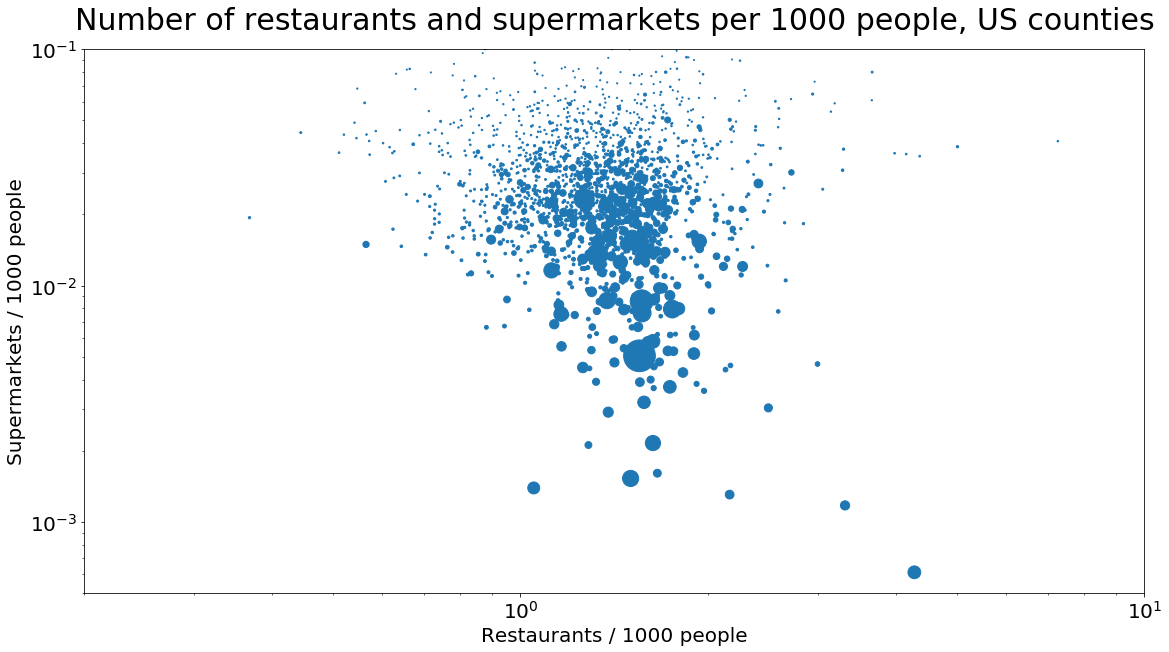

In [19]:
# Scatter plot, with point-size proportional to county population.
ax = df_FEA_prs.plot.scatter(x='tot_per_1000pop14', y='SUPERCPTH14',
                             s=df_FEA_prs['Population Estimate, 2014']/10**4, figsize=(19,10))

# Convert to log scale
ax.set_yscale('log')
ax.set_xscale('log')

# Set axis limits
ax.set_xlim([0.2, 10])
ax.set_ylim([0.0005, 0.1])

# Set axis labels
ax.set_xlabel("Restaurants / 1000 people", fontsize=20)
ax.set_ylabel("Supermarkets / 1000 people", fontsize=20)

# Set axis ticks fontsize
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)

# Set title
ax.set_title("Number of restaurants and supermarkets per 1000 people, US counties", fontsize=30, pad=20)

There is really no correlation at all between the restaurant density and the supermarket density. This can be confirmed by calculating the correlation coefficient:

In [20]:
# Calculate correlation coefficient.
df_FEA_prs['tot_per_1000pop14'].corr(df_FEA_prs['SUPERCPTH14'])

0.061921920718792905

There is no significant correlation between the restaurant density and supermarket density, giving us some evidence to reject the hypothesis that the places with low restaurant density are due to people preferring to buy supermarket food to eat in rather than eat out at restaurants.

## Going forward
From here, more hypotheses for the distribution of restaurant density in the US must be tested. In the Food Environment Atlas dataset, there are many, many columns, only a small numbe rof which have been investigated here. The next step would be to determine which parameters are strongly correlated with each other.

By implementing feature selection by Principle Component Analysis, I would reduce the number of parameters to only those that independently vary. From there I could build a regression predictive model to help determine which county would be most profitable for anew restaurant.